In [67]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


from geopy.geocoders import Nominatim
from geopy.geocoders import options

In [ ]:
# загрузка данных
data_sold_flats = pd.read_csv('sold_flats_2020-09-30.csv', sep=",")
display(data_sold_flats.info())

In [ ]:
# Определяем расположение объектов недвижимости по координатам используя https://geopy.readthedocs.io/en/stable/index.html
# При наличии координат находим город, регион, страну иначе возвращаем None

data_sold_flats = pd.read_csv('sold_flats_2020-09-31.csv', sep=",")
options.default_user_agent = "find_city"


def find_location(geolocator, lat, lon):
    try:
        location = geolocator.reverse(f"{lat}, {lon}")
        address = location.raw['address']
        city = address.get('city', np.nan)
        region = address.get('state', np.nan)
        country = address.get('country', np.nan)
    except Exception:
        city = np.nan
        region = np.nan
        country = np.nan

    display(city, region, country)
    return city, region,country



geolocator = Nominatim(user_agent='find_city')



data_sold_flats[['city', 'region', 'country']] = data_sold_flats.apply(lambda row: pd.Series(find_location(geolocator, row['latitude'], row['longitude'])), axis=1)

data_sold_flats.to_excel('data_sold_flats_location.xlsx', index=False)

In [ ]:
#применяется при загрузке стороннего файла c локациями (решение ошибки с "badzip file")
# data_sold_flats_location = pd.read_excel('data_sold_flats_location.xls')
# data_sold_flats_location.to_excel('data_sold_flats_location.xlsx', index=False)

In [ ]:
data_sold_flats_location = pd.read_excel('data_sold_flats_location.xlsx')
display(data_sold_flats_location.head(10))

In [ ]:
# поиск дубликатов, создание словаря, удаление из датасета
duplicates_id = []
duplicates = data_sold_flats_location.copy()

for i in (duplicates[duplicates[['city_id', 'district_id', 'street_id', 'price', 'date_sold', 'sold_price', 'longitude', 'latitude', 'floor_num', 'floors_cnt', 'rooms_cnt', 'building_year', 'area_total', 'area_live', 'series_id', 'wall_id', 'ceiling_height', 'bathroom', 'bedrooms_cnt']].duplicated()]['id']):
  duplicates_id.append(i)


data_sold_flats_location = data_sold_flats_location[~data_sold_flats_location['id'].isin(duplicates_id)]

print(f'удалены позиции: {duplicates_id}')



In [ ]:
# Список стран

unique_country = data_sold_flats_location['country'].unique().tolist()
display(f"Список стран, где продана недвижимость: {unique_country}")


# удаляем ненужные значения из списка стран, для фильтрации лишних городов
countries = []
for i in unique_country:
  if str(i) != 'nan' and str(i) != 'Россия':
    countries.append(i)

display(countries)


# Выбираем только строки, где не Россия и не nan
mask = data_sold_flats_location['country'].isin(countries)

unique_city_id_foreign_country = data_sold_flats_location[mask].sort_values(by='city_id', ascending=False)['city_id'].unique().tolist()

display(f"Список 'city_id' иностранных городов: {unique_city_id_foreign_country}")



In [ ]:
# Проверка списка 'city_id' иностранных городов
data_sold_flats_foreign_country = data_sold_flats_location.copy()

# Меняем NaN на 'NaN' для nunique()
data_sold_flats_foreign_country[['city_id', 'city', 'region', 'country']] = data_sold_flats_foreign_country[['city_id', 'city', 'region', 'country']].fillna(value="NaN")

# Фильтруем DataFrame по списку уникальных идентификаторов городов
filtered_df = data_sold_flats_foreign_country[data_sold_flats_foreign_country['city_id'].isin(unique_city_id_foreign_country)]

# Группируем DataFrame по столбцам 'city_id', 'city', 'region', 'country' и считаем количество уникальных значений в каждой группе
result = filtered_df.groupby(['city_id', 'city', 'region', 'country']).nunique()


result = result.reset_index()[['city_id', 'city', 'region', 'country']]
display(result)


unique_city_id_foreign_country_update = []

for i in result['city_id']:
  if i not in unique_city_id_foreign_country_update:
    unique_city_id_foreign_country_update.append(i)

print(unique_city_id_foreign_country_update)


In [72]:
# Удаляем иностранные города (1066 - пока не удаляем!)
unique_city_id_foreign_country_update = [577,  373,  236,  201]
print(unique_city_id_foreign_country_update)

data_sold_flats_foreign_country = data_sold_flats_foreign_country[~data_sold_flats_foreign_country['city_id'].isin(unique_city_id_foreign_country_update)]


[577, 373, 236, 201]


In [73]:
# город Энгельс имеет city_id = 1105. заменяем все г. Энгельс на city_id = 1105

data_sold_flats_foreign_country['city_id'] = np.where(data_sold_flats_foreign_country['city'] == 'Энгельс', 1105, data_sold_flats_foreign_country['city_id'])

# после чего удаляем оставшиеся иностраные города с city_id = 1066
unique_city_id_foreign_country_update = [1066]
data_sold_flats_foreign_country = data_sold_flats_foreign_country[~data_sold_flats_foreign_country['city_id'].isin(unique_city_id_foreign_country_update)]

In [ ]:
# Определяем название городам и регионам у которых значение NaN

pd.set_option('display.max_rows', None)

# Меняем NaN на 'NaN' для nunique()
data_sold_flats_city_region = data_sold_flats_foreign_country.copy()
data_sold_flats_city_region["city"].fillna(value="NaN", inplace=True)
data_sold_flats_city_region["region"].fillna(value="NaN", inplace=True)

# Группируем и считаем количество уникальных записей по каждому city_id
grouped = data_sold_flats_city_region.groupby(['city_id', 'city', 'region']).nunique()
unique_rows = grouped[grouped.columns[:1]]
unique_rows.columns = ['count']

# Сортируем по убыванию количества уникальных записей
unique_rows = unique_rows.sort_values(by=['city_id', 'count'], ascending=[True, False])

# Определяем наиболее частый регион и город для каждого city_id
most_common_region = {}
most_common_city = {}

for city_id, group in unique_rows.reset_index().groupby('city_id'):
    region_values = group['region'].values
    city_values = group['city'].values

    for value in region_values:
        if value != 'NaN':
            most_common_region[city_id] = value
            break

    if city_id not in most_common_region:
        most_common_region[city_id] = 'NaN'

    for value in city_values:
        if value != 'NaN':
            most_common_city[city_id] = value
            break

    if city_id not in most_common_city:
        most_common_city[city_id] = 'NaN'


# Добавляем новые столбцы с самым частым регионом и городом для каждого city_id
unique_rows['most_common_city'] = unique_rows.index.get_level_values('city_id').map(most_common_city)
unique_rows['most_common_region'] = unique_rows.index.get_level_values('city_id').map(most_common_region)


display(unique_rows)

pd.reset_option('display.max_rows')

In [ ]:
# Итоговый список названий городов и регион по 'city_id'

pd.set_option('display.max_rows', None)

df_city = pd.DataFrame.from_dict(most_common_city, orient='index', columns=['city'])
df_region = pd.DataFrame.from_dict(most_common_region, orient='index', columns=['region'])

df_city_region = pd.concat([df_city, df_region], axis=1).reset_index().rename(columns={'index': 'city_id'})

grouped = data_sold_flats_city_region.groupby('city_id').size().reset_index(name='count')
df_city_region = df_city_region.merge(grouped, on='city_id', how='left')

display(df_city_region)

pd.reset_option('display.max_rows')

In [76]:
# Обновляем столбцы 'city', 'region', (исключаем NaN)

data_sold_flats_city_region.drop(columns=['city', 'region'], inplace=True)

data_sold_flats_city_region = data_sold_flats_city_region.merge(df_city_region[['city_id', 'city', 'region']], on='city_id', how='left')
data_sold_flats_city_region[['city', 'region']] = data_sold_flats_city_region[['city', 'region']].replace('NaN', None)

In [ ]:
# 'city_id', где есть метро:
# {45 - Екатеринбург,
# 135 - Новосибирск,
# 155 - Москва,
# 166 - МО,
# 180 - Казань}

# Создаем новый столбец 'isMetro' - находиться в городе метро (1) или нет (0)


data_sold_flats_metro = data_sold_flats_city_region.copy()

metro_city_id = [45, 135, 155, 166, 180] # Список 'city_id', где есть метро
data_sold_flats_metro['isMetro'] = data_sold_flats_metro['city_id'].apply(lambda x: 1 if x in metro_city_id else 0)

# display(data_sold_flats_metro.head(1000))
display(data_sold_flats_metro.loc[data_sold_flats_metro['isMetro'] == 1])



In [78]:
# Меняем всем городом, где нет метро, значение metro_station_id на 0, а для городов, где есть метро меняем -1 и NaN на 1
data_sold_flats_metro['metro_station_id'] = data_sold_flats_metro.apply(lambda x: 0 if x['isMetro'] == 0 else x['metro_station_id'], axis=1)
data_sold_flats_metro['metro_station_id'] = data_sold_flats_metro.apply(lambda x: 0 if x['isMetro'] == 1 and ((x['metro_station_id'] == -1) or (pd.isna(x['metro_station_id']))) else x['metro_station_id'], axis=1)



In [ ]:
Удаляем столбцы
"status" - все квартиры уже проданы
"price" - используем "sold_price"
"loggia" - 100 % пропусков
"country" - удаляем из-за ненадобности
"longitude" - удаляем из-за ненадобности
"latitude" - удаляем из-за ненадобности


"date_sold" - удаляем из-за ненадобности
"flat_on_floor" - 95.56 % пропусков

"plate" - 54.32 % пропусков
"komunal_cost" - 89.72 % пропусков
"closed_yard" - 95.57 % пропусков

"area_balcony" - 81.80 % пропусков
"area_kitchen" - 58.00 % пропусков
"area_live" - 67.45 % пропусков
"levels_count" - 98.57 % содержат значение 1
"ceiling_height" - 90 % квартир имеют высоту потолков от 2,5 до 3 метров




In [ ]:
data_sold_flats_delete_columns = data_sold_flats_metro.copy()
data_sold_flats_delete_columns = data_sold_flats_delete_columns.drop(columns=[

                                                                    'status',
                                                                    'price',

                                                                    'loggia',
                                                                    'flat_on_floor',
                                                                    'plate',
                                                                    'komunal_cost',
                                                                    'closed_yard',
                                                                    'area_balcony',
                                                                    'area_live',
                                                                    'area_kitchen',
                                                                    'levels_count',
                                                                    'ceiling_height',
                                                                    'country',
                                                                    'longitude',
                                                                    'latitude',

                                                                    ],axis = 1)
data_sold_flats_delete_columns.info()

In [ ]:
# Заменяем значение "-1" у столбца 'district_id' на NaN
data_sold_flats_delete_columns['district_id'] = data_sold_flats_delete_columns['district_id'].replace(-1, np.nan)

# Заменяем "0" у столбцов 'rooms_cnt','wall_id', 'series_id','floors_cnt' на NaN
data_sold_flats_delete_columns['rooms_cnt'] = data_sold_flats_delete_columns['rooms_cnt'].replace(0, np.nan)
data_sold_flats_delete_columns['wall_id'] = data_sold_flats_delete_columns['wall_id'].replace(0, np.nan)
data_sold_flats_delete_columns['series_id'] = data_sold_flats_delete_columns['series_id'].replace(0, np.nan)
data_sold_flats_delete_columns['floors_cnt'] = data_sold_flats_delete_columns['floors_cnt'].replace(0, np.nan)

# Удаляем строки, где малое количество пропущенных значений, в столбцах 'area_total', 'two_levels', 'balcon', 'bathroom', 'windows', 'keep', 'floors_cnt', 'floor_num', 'sold_price', 'region', 'district_id', 'wall_id', 'series_id'

data_sold_flats_delete_columns = data_sold_flats_delete_columns.dropna(
    subset=['area_total', 'two_levels', 'balcon', 'bathroom', 'windows', 'keep', 'floors_cnt',
            'floor_num', 'sold_price', 'region', 'district_id', 'wall_id', 'series_id'])

# Меняем пропущенные значения (Null или 0) на 1 в столбце 'bathrooms_cnt'

data_sold_flats_delete_columns['bathrooms_cnt'] = data_sold_flats_delete_columns['bathrooms_cnt'].fillna(1)
data_sold_flats_delete_columns['bathrooms_cnt'] = data_sold_flats_delete_columns['bathrooms_cnt'].replace(0, 1)



In [ ]:
# Находим список некорректных значений в столбце 'building_year'

unique_values = data_sold_flats_delete_columns.loc[
    data_sold_flats_delete_columns['building_year'].apply(
        lambda x: (isinstance(x, str) or (not np.isnan(x) and len(str(int(x))) != 4))
        if pd.notna(x) else False
    ), 'building_year'].unique()
display(sorted(list(unique_values)))


# Исправляем некорректные значения в столбце 'building_year'

def clean_year(year):
    if year < 20:
        year += 2000
    elif year < 100:
        year += 1900
    elif year == 101:
        year = 2001
    elif year == 168:
        year = 1968
    elif year == 41986:
        year = 1986
    return int(year)

data_sold_flats_delete_columns['building_year'] = data_sold_flats_delete_columns['building_year'].apply(lambda year: clean_year(year) if pd.notna(year) else year)



In [83]:
display(data_sold_flats_delete_columns['territory'].unique() )

array(['parking,closed,elevator',
       'parking,guest_parking,yard_opened,elevator',
       'parking,yard_opened,without_elevator', ...,
       'child_place,parking,closed,yard_gate,yard_security,without_elevator',
       'yard_opened,no_parking,without_elevator,dog_yard',
       'child_place,parking,garage_parking,closed,video_monitoring,elevator'],
      dtype=object)

In [84]:
# Label Encoding в столбцах 'keep', 'balcon', 'two_levels', 'type', 'bathroom', 'windows', 'city', 'region', 'territory'

def labelEncoding(df, cols):
    for col in cols:
        codes, uniques = pd.factorize(df[col])
        df[col] = codes
    return df

column_name = ['keep', 'balcon', 'two_levels', 'type', 'bathroom', 'windows', 'city', 'region', 'territory']
# for i in column_name:
data_sold_flats_delete_columns = labelEncoding(data_sold_flats_delete_columns, column_name)



In [ ]:
# анализ выбросов
pd.set_option('display.max_colwidth', 100)

data_sold_flats_q = data_sold_flats_delete_columns.copy()

df_table = pd.DataFrame(
    {'Название столбца': [], 'q1 [Кол-во]': [], 'q2 [Кол-во], min [Значение], max [Значение]': [], 'q3 [Кол-во], min [Значение], max [Значение]': []}
)

df_column_name = [
    'sold_price', 'floor_num', 'floors_cnt', 'rooms_cnt', 'bedrooms_cnt', 'building_year',
    'area_total', 'bathrooms_cnt', 'wall_id', 'series_id'
]

for column_name in df_column_name:
    print(column_name)
    q1 = data_sold_flats_q[column_name].quantile(0.25)
    q3 = data_sold_flats_q[column_name].quantile(0.75)
    iqr = q3 - q1
    left_line = q1 - 1.5 * iqr
    right_line = q3 + 1.5 * iqr
    value_1 = data_sold_flats_q[(data_sold_flats_q[column_name] <= left_line)][column_name].sort_values(ascending=False)
    value_2 = data_sold_flats_q[(data_sold_flats_q[column_name] > left_line) & (data_sold_flats_q[column_name] < right_line)][column_name].sort_values(ascending=False)
    value_3 = data_sold_flats_q[(data_sold_flats_q[column_name] >= right_line)][column_name].sort_values(ascending=False)

    df_table.loc[len(df_table.index)] = [
        str(column_name), f'{left_line}: [ {value_1.shape[0]} ]',
        f'q2: [ {value_2.shape[0]} ],  min:[ {value_2.min()} ],  min:[ {value_2.max()} ]',
        f'{right_line}: [ {value_3.shape[0]} ],  min:[ {value_3.min()} ],  min:[ {value_3.max()} ]]'
    ]

display(df_table)

pd.reset_option('display.max_colwidth')

In [86]:
#  Удаляем выбросы в столбце 'sold_price', где значение меньше 1000 или больше 10 000 000
data_sold_flats_q = data_sold_flats_q.drop(data_sold_flats_q[(data_sold_flats_q['sold_price'] < 1000)|(data_sold_flats_q['sold_price'] >= 10000000)].index)


# Приводим значение в столбце 'sold_price' к одной единице измерения
def price_standard(price):
    new_price = str(int(price))
    while len(new_price) < 7:
        new_price += '0'
    return int(new_price)

data_sold_flats_q['sold_price'] = data_sold_flats_q['sold_price'].apply(price_standard)

In [87]:
# Удаляем выбросы в столбце 'area_total', где значение меньше 10 и больше 500

data_sold_flats_q = data_sold_flats_q.drop(data_sold_flats_q[(data_sold_flats_q['area_total'] < 10) |
                                                                   (data_sold_flats_q['area_total'] > 500)].index)

In [88]:
# Удаляем выбросы в столбцах 'floor_num', 'floors_cnt', 'rooms_cnt', 'bedrooms_cnt', 'building_year', 'bathrooms_cnt'

df_column_name = ['floor_num', 'floors_cnt', 'rooms_cnt', 'bedrooms_cnt', 'building_year', 'bathrooms_cnt']

for column_name in df_column_name:
    q1 = data_sold_flats_q[column_name].quantile(0.25)
    q3 = data_sold_flats_q[column_name].quantile(0.75)
    iqr = q3 - q1
    left_line = q1 - 1.5 * iqr
    right_line = q3 + 1.5 * iqr
    value = data_sold_flats_q[(data_sold_flats_q[column_name] < left_line) | (data_sold_flats_q[column_name] > right_line)][column_name].unique()
    data_sold_flats_q = data_sold_flats_q[~data_sold_flats_q[column_name].isin(value)]

In [89]:
# Добавляем столбец 'price_per_sqm' - цена за квадратный метр

data_sold_flats_q['price_per_sqm'] = data_sold_flats_q['sold_price'] / data_sold_flats_q['area_total']

In [90]:
# Заменяем NaN на медианное значение в столбцах 'bedrooms_cnt', 'building_year', 'rooms_cnt' отсортированным по столбцу 'series_id'


def replace_nan_median(row):

    df_column_name = ['rooms_cnt', 'bedrooms_cnt', 'building_year']

    for column_name in df_column_name:
        if pd.isna(row[column_name]):
          value = data_sold_flats_q[data_sold_flats_q['series_id'] == row['series_id']][column_name].median()
          if pd.isna(value):
                return row
          row[column_name] = round(value)

    return row

data_sold_flats_q = data_sold_flats_q.apply(replace_nan_median, axis=1)
data_sold_flats_q = data_sold_flats_q.dropna(subset=['rooms_cnt', 'bedrooms_cnt','building_year'])

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local

In [94]:
# Строим матрицу корреляции
# С целевой переменной 'sold_price' коррелирую следующие признак: 'floors_cnt','rooms_cnt','building_year','area_total','price_per_sqm'


data_sold_flats_matrix=data_sold_flats_q.copy()
data_sold_flats_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58779 entries, 0 to 70285
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                58779 non-null  int64         
 1   city_id           58779 non-null  int64         
 2   district_id       58779 non-null  float64       
 3   street_id         58779 non-null  int64         
 4   date_sold         58779 non-null  datetime64[ns]
 5   sold_price        58779 non-null  int64         
 6   metro_station_id  58779 non-null  float64       
 7   floor_num         58779 non-null  float64       
 8   floors_cnt        58779 non-null  float64       
 9   rooms_cnt         58779 non-null  float64       
 10  bedrooms_cnt      58779 non-null  float64       
 11  building_year     58779 non-null  float64       
 12  area_total        58779 non-null  float64       
 13  builder_id        58779 non-null  int64         
 14  type              5877

In [108]:

# list_name_columns = ['city_id','district_id','street_id', 'metro_station_id','sold_price', 'floor_num', 'floors_cnt', 'bedrooms_cnt','building_year','bathrooms_cnt','territory','series_id','wall_id','keep','windows','balcon','rooms_cnt','type','two_levels','bathroom']
list_name_columns = ['metro_station_id','sold_price', 'floor_num', 'floors_cnt', 'bedrooms_cnt','building_year','bathrooms_cnt','territory','series_id','wall_id','keep','windows','balcon','rooms_cnt','type','two_levels','bathroom']

for column_name in list_name_columns:
    print(column_name)
    data_sold_flats_matrix[column_name] = data_sold_flats_matrix[column_name].astype(int)


# list_name_columns = ['metro_station_id','sold_price', 'floor_num', 'floors_cnt', 'bedrooms_cnt','building_year','bathrooms_cnt','territory','series_id','wall_id','keep','windows','balcon','rooms_cnt','type','two_levels','bathroom']
list_name_columns = ['id', 'city_id','district_id','street_id','type', 'bathroom', 'windows', 'keep', 'balcon','series_id','wall_id']

for column_name in list_name_columns:
    data_sold_flats_matrix[column_name] = data_sold_flats_matrix[column_name].astype('category')

list_name_columns = ['id',]





metro_station_id
sold_price
floor_num
floors_cnt
bedrooms_cnt
building_year
bathrooms_cnt
territory
series_id
wall_id
keep
windows
balcon
rooms_cnt
type
two_levels
bathroom


<ipython-input-109-b9b1fb811da2>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_sold_flats_matrix.corr()


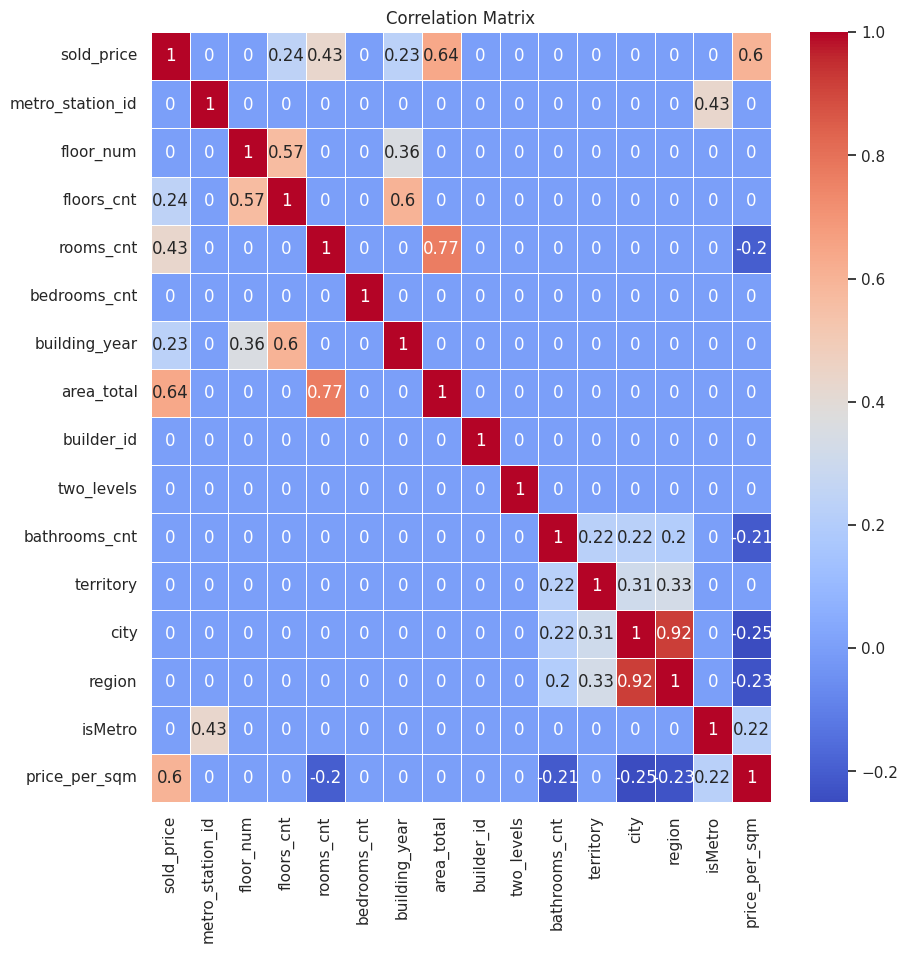

In [109]:
# Выводим матрицу

plt.figure(figsize=(10, 10))
sns.set(font_scale=1)

correlation_matrix = data_sold_flats_matrix.corr()
correlation_matrix = np.round(correlation_matrix, 2)
correlation_matrix[np.abs(correlation_matrix) < 0.2] = 0

sns.heatmap(correlation_matrix, annot=True, linewidths=0.5, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

In [111]:
# Сохраняем пред обработанный датасет в Excel
data_sold_flats_matrix = data_sold_flats_matrix.drop(columns=['id'],axis = 1)
data_sold_flats_matrix.to_excel('data_sold_flats_result.xlsx', index=False)